In [1]:
import numpy as np
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

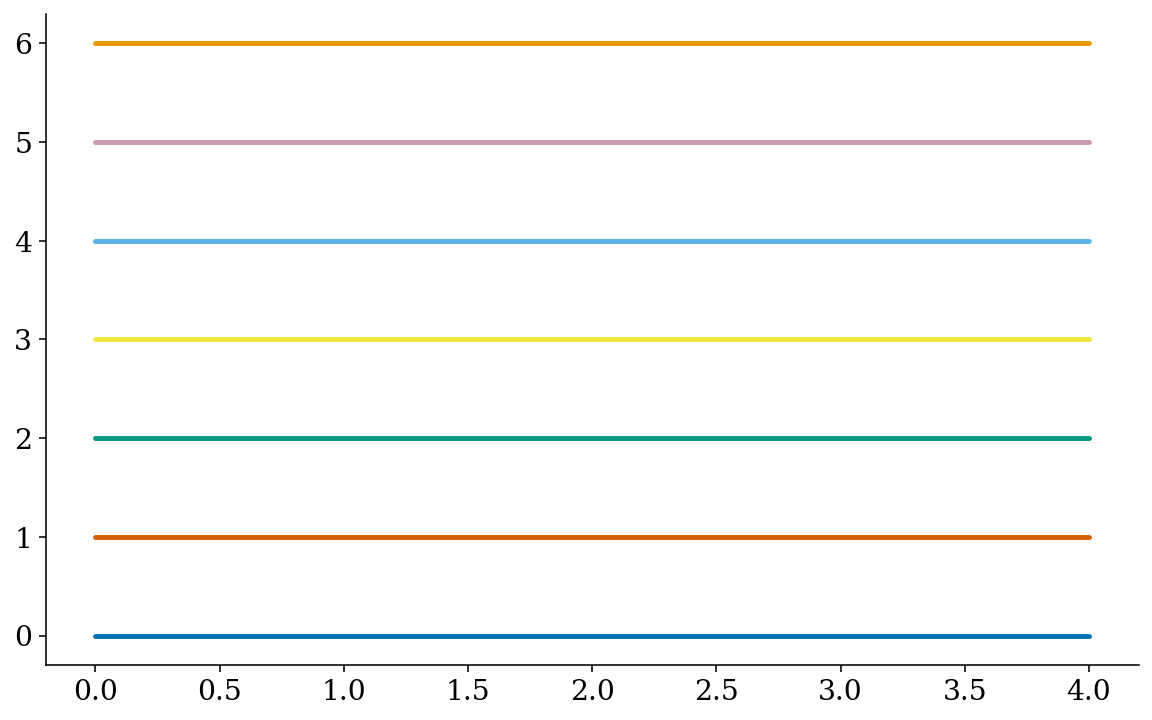

In [8]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (10,6)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
for i,c in enumerate(colorblind_colors):
    plt.plot((i)*np.ones(5),c=c)

In [84]:

def mtanh(r, p):
    height = p[0] #
    sep = p[1] # offset
    slope = p[2]
    pos = p[3]
    wid = p[4]

    a = (height-sep)/2
    x = 4*(pos-r)/wid
    m = slope*wid/4
    y = a*(((1 - m*x)*np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))+1) + sep
    return y


def mtanh_res(params, x_data, y_data, y_err):
    y_model = mtanh(x_data, params)
    res = (y_data - y_model)/y_err
    return res


def fit_mtanh(x_data, y_data, y_err=None):

    if y_err is None:
        y_err = np.ones(y_data.shape)
        y_err[np.abs(y_data)<1e-10] = 1e30

    p0 = np.array([1.0, 0.1, 2, 1.0, 0.01])
    pmin = np.array([0.1, 0.000, -10, 0.85, 0.01])
    pmax = np.array([np.inf, 0.5, 10, 1.15, np.inf])

    kwargs = {'x_data': x_data,
              'y_data': y_data,
              'y_err': y_err}
    fit_out = least_squares(mtanh_res,
                            p0,
                            jac='2-point',
                            bounds=(pmin, pmax),
                            method='trf',
                            ftol=1e-08,
                            xtol=1e-08,
                            gtol=1e-08,
                            x_scale=1.0,
                            loss='linear',
                            f_scale=1.0,
                            diff_step=None,
                            tr_solver=None,
                            tr_options={},
                            jac_sparsity=None,
                            max_nfev=200,
                            verbose=0,
                            args=(),
                            kwargs=kwargs)
    return fit_out.x


def fit_profile(x_data, y_data, y_err=None):
    if y_err is None:
        y_err = np.ones(y_data.shape)
        y_err[np.abs(y_data)<1e-10] = 1e30

    p = fit_mtanh(x_data, y_data, y_err)
    x121 = np.linspace(0, 1.2, 121)
    y121 = mtanh(x121, p)
    x65 = np.linspace(0, 1, 65)
    y65 = interp1d(x121, y121, 'linear',
                   fill_value='extrapolate', assume_sorted=True)(x65)
    return y121


In [92]:
def square_exp_kernel(x1,x2, sigma=1, l=0.3):
    return sigma**2*np.exp(-(x1.reshape((x1.size,1))-x2.reshape((1,x2.size)))**2/(2*l**2))


def gibbs_kernel(x1,x2, sigma=0.5, l1=1,l2=.5,lw=0.01, x0=.96):
    
    
    def lfunc(x):
        return (l1 + l2)/2 - (l1 - l2)/2*np.tanh((x-x0)/lw)
    
    den = lfunc(x1).reshape((x1.size,1))**2+lfunc(x2).reshape((1,x2.size))**2
    prefactor = sigma**2*np.sqrt(2*lfunc(x1).reshape((x1.size,1))*lfunc(x2).reshape((1,x2.size))/den)
    return prefactor*np.exp(-(x1.reshape((x1.size,1))-x2.reshape((1,x2.size)))**2/den)
    
    
def GPR(xq,x,y,y_unc,kernel=gibbs_kernel):
    sigma_n = np.diag(y_unc)

    K1 = kernel(xq,x)
    K2 = kernel(x,x)
    K3 = kernel(xq,xq)

    temp = np.linalg.inv(K2+sigma_n)
    mu = np.matmul(np.matmul(K1,temp),y)
    unc = K3 - np.matmul(np.matmul(K1,temp),K1.T)
    return mu, unc

In [93]:
xtrue = np.linspace(0,1.2,1000)
p0 = np.array([.5, 0, -6, .96, 0.1])
ytrue = mtanh(xtrue,p0)

In [108]:
n_meas = 40
y_err = 0.1*np.ones(x_meas.shape)
x_meas = np.sort(1.2*np.random.random(n_meas))
y_meas = np.interp(x_meas,xtrue,ytrue) + y_err*np.random.normal(size=x_meas.shape)

In [111]:
x121 = np.linspace(0,1.2,121)

yGPR, uncGPR = GPR(x121,x_meas,y_meas,2*y_err,kernel=gibbs_kernel)
y_mtanh = fit_profile(x_meas,y_meas,2*y_err)


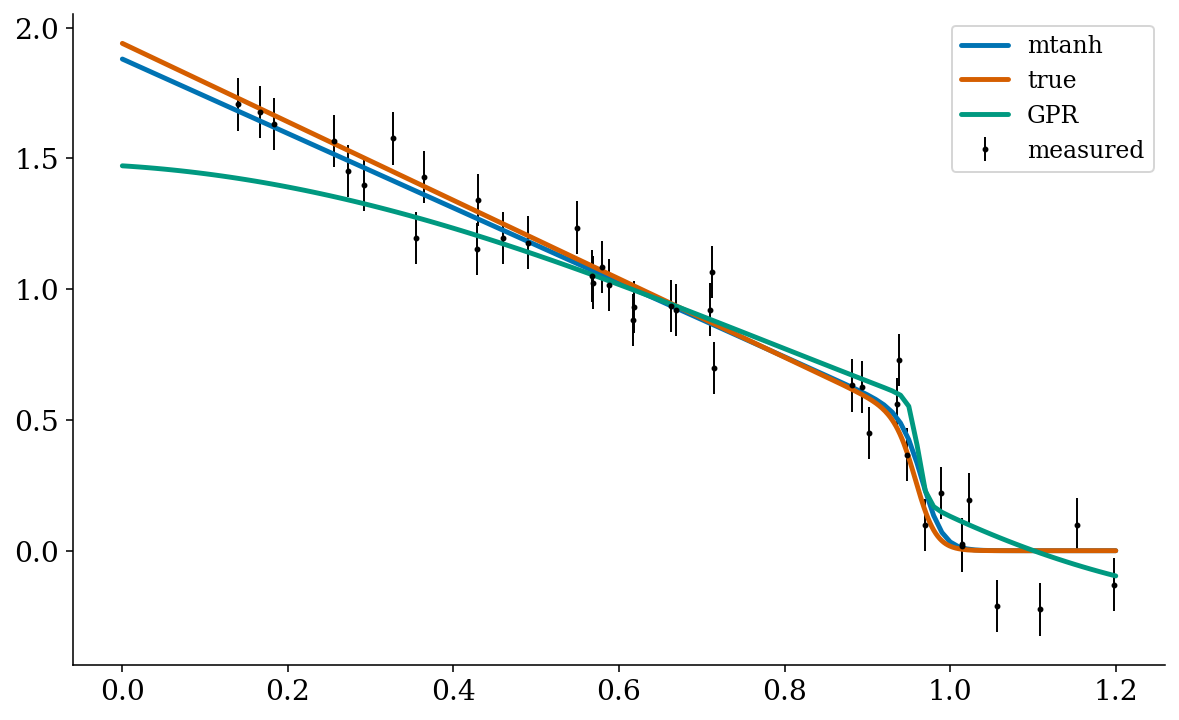

In [112]:
plt.plot(x121,y_mtanh,label='mtanh')
plt.plot(xtrue,ytrue,label='true')
plt.errorbar(x_meas,y_meas,y_err,label='measured',c='k',marker='o',markersize=2,linestyle='',elinewidth=1)
plt.plot(x121,yGPR,label='GPR')
plt.legend()

In [90]:
%%timeit
y_mtanh = fit_profile(x_meas,y_meas,y_err)

6.6 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
%%timeit
yGPR, uncGPR = GPR(x121,x_meas,y_meas,y_err,kernel=gibbs_kernel)


598 µs ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
